# Analysis of the Neural Tangent Kernel: Convergence and Generalization

## Problem Statement

### Abstract

  Deep neural network has been widely used nowadays but understanding its inner workings during training and why it generalizes so well is still an active area of research. NTKs(Neural Tangent Kernels) is one of the kernels in recent development that provides a framework for analyzing the evolution of deep-neural networks during training. It is introduced by by Arthur Jacot, Franck Gabriel and Clément Hongler in 2018. [Neural Tangent Kernel: Convergence and Generalization in Neural Networks](https://arxiv.org/abs/1806.07572)<br>

This analysis aims to provide an in-depth understanding of the neural tangent kernel(NTK), including its properties, limitations, and future research directions. Additionally, the study introduces a concept known as "lazy training"; which refers to a phenomenon that occurs when training a over-parameterized neural network. In such instances, the training loss tends to converge rapidly to zero but the corresponding network parameters hardly change. NTK provides an explanation for the reasons behind this phenomenon.<br>


### Motivation

The paper explains that ANNs can approximate any function with sufficiently many hidden neurons but it is not known what optimization ANNs converge to. Because at initialization, ANNs are equivalent to Gaussian processes, kernel methods can be applied to the problem. The exploration of NTKs bring new results that provides further insight on ANNs during training.

## Main Result

### Neural Tangent Kernel

#### Set Up

Fundamentally, NTKs explain how modification of the model parameters on a singular data sample influences the projections for other samples.<br>
<br>
Let us set up a $L$ depth fully connected neural network with parameter θ, and a nonlinear $Lipschitz$ continuous function σ(). Indexed each layer as $1...L$, and the number of neurons in each layer denoted as $n_0...n_L$. The forward pass computation in each layer is:<br>
<br>
$${α}^{(0)}(x;θ) = x$$
<br>
$$̃α^{(l+1)}(x;θ) = \sqrt{n_l}^{-1}W^{(l)}α^{(l)}(x;θ)+βb^{(l)}$$
<br>
$$α^{(l)}(x;θ)=σ(̃α^{(l)}(x;θ))$$
<br>
Where $̃α(x;θ)$ is pre-activation function, and $α(x;θ)$ is activation function. <br>
<br>



#### Gussian Processes

Define an output function of the neural network $f(.;θ):{R}^{n_0} → {R}^{n_L}$ in space $𝐹$. At the initialization in infinite-width limit ($n_0...n_L → ∞$) DNNs is equivalent to Gaussian process with covariance ${𝝨}^{(L)}$ defined as<br>
<br>
$${𝚺}^{(1)}(x,x') = {n_0}^{-1}x^Tx'+β^2$$ 
<br>
$${𝚺}^{L+1}(x,x') = {E}_{f ∼ N(0, {𝚺}^{L})}[σ(f(x))σ(f(x'))]+β^2$$
<br>

#### Neural Tangent Kernel

Training ANN is typically involves optimizing the function $f_θ$ within the function space $𝐹$ by minimizing the cost function $C: 𝐹→R$. In the context of optimizing a cost function using gradient descent, the dynamics of $f_θ$ is follow kernel gradient descent with respect to the NTK. <br>
<br>
The multi-dimensional kernel: **Neural Tangent Kernel** K is a function $R^{n_0 × n_0} → R^{n_L × n_L}$, and defined as:<br>
<br>
$$K(x, x';θ) = ∇_θ f(x;θ)^T∇_θ f(x';θ)$$
<br>
And during kernel gradient descent, the evolution of the cost C is shown as:<br>
<br>
$$\partial{t}C|_{f_t} = -||d|_{f(t)}||_K^2$$
<br>
By above formula and because the kernel matrix K is positive definite, we can summarise that: If the cost function is convex and bounded from below, the function $f(t)$ is converge to global minimum as $t→∞$.


#### Code

In [ ]:
!pip install imageio
!pip install ipywidgets
!pip install pytorch-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.1/492.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00
  Created wheel for pytorch-utils: filename=pytorch_utils-0.5.5-py3-none-any.whl size=14290 sha256=cf0529e1695e9c8cfb74f138c60ceb69fd85d03

In [ ]:
!mkdir figs
!mkdir gifs
!mkdir gifs/ellipses

In [ ]:
import torch
from torch import optim, nn
from tqdm import tqdm, tqdm_notebook

In [ ]:
def create_net(width,
               bias=True,
               hidden_layers=1,
               **kwargs):
    """A simple 1d input to 1d output deep ReLU network.

    Parameters
    ----------
    width : int
        width of hidden layers
    bias : bool
        Whether to include biases.
    hidden_layers : int
        Number of hidden layers
    
    """
    model = nn.Sequential(nn.Linear(1, width, bias=bias),
                          nn.ReLU(),
                          *[layer
                            for _ in range(hidden_layers-1)
                            for layer in [nn.Linear(width, width, bias=bias), nn.ReLU()]
                            ],
                          nn.Linear(width, 1, bias=bias))

    return model

def gd(model, xdata, ydata,
       iters=100,
       lr=1e-3,
       progress_bar=True,
       eps=1e-10):
    """Run gradient descent using square loss on the model with the given data.

    Updates the given model instance.

    Parameters
    ----------
    eps : float
        Stop if the loss reduces below this value.

    Returns
    -------
    list of loss values

    """

    opt = optim.SGD(model.parameters(), lr=lr)
    losses = []

    item = -1
    t = range(iters)
    if progress_bar:
        t = tqdm(t)
    for i in t:
        out = model(xdata)

        # normalizing the loss:
        loss = nn.MSELoss()(out, ydata)

        # we store the unnormalized losses
        litem = loss.item()
        losses.append(litem)
        if progress_bar:
            t.set_postfix(loss=litem)
        
        if litem < eps:
            return losses
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses

In [ ]:
from pytorch_utils.nb_figure import NBFigure
import imageio

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
matplotlib.rcParams['figure.figsize'] = 12,9
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 3

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import math

#xin = torch.tensor([-3, 0.5]).unsqueeze(1)
#yin = torch.tensor([2, -1.0]).unsqueeze(1)
xin = torch.tensor([-math.pi*1/4, math.pi*1/8, math.pi*1/3]).unsqueeze(1).to(device)
yin = (torch.sin(xin) * torch.cos(xin)).to(device)

In [ ]:
m = 1000

In [ ]:
nbf = NBFigure('train_fig.png')
ax = nbf.getAxis()
nbf.set_xlim((-math.pi/2, math.pi/2))
nbf.set_ylim((-1, 1))
ax.scatter(xin.detach().cpu(), yin.detach().cpu(), color='red', s=80)
ax.set_title(f"Width={m}")
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x, w)$")

Text(4.444444444444452, 0.5, '$f(x, w)$')

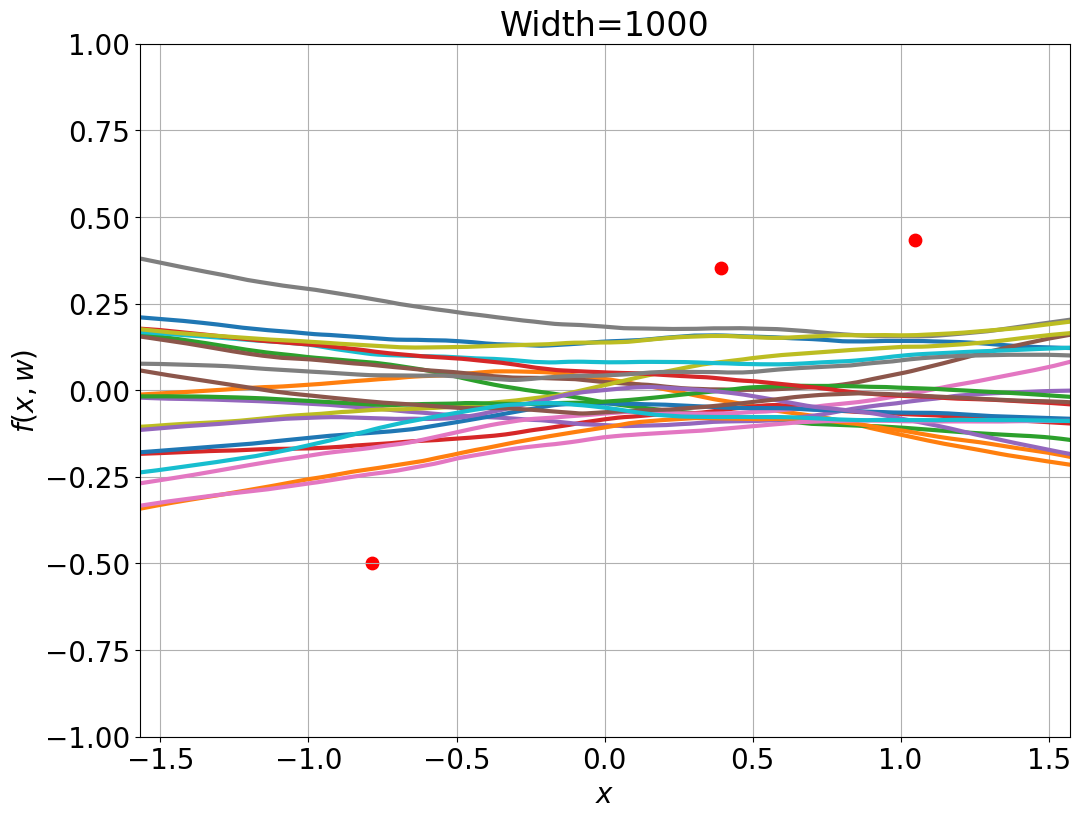

<ipython-input-11-f0e678297769>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im0 = imageio.imread('train_fig.png')


<Figure size 1200x900 with 0 Axes>

In [ ]:
x = torch.linspace(-math.pi/2, math.pi/2, 1000).unsqueeze(1).to(device)

b = True
count = 20
depth = 2
alpha = 1
all_nets = [create_net(width=m, bias=b, hidden_layers=depth).to(device) for _ in range(count)]
lines = []
for net in all_nets:
    l, = ax.plot(x.detach().cpu(), net(x).detach().cpu())
    lines.append(l)

nbf.display()
nbf.update()
plt.savefig("train_fig1.png")
im0 = imageio.imread('train_fig.png')

<ipython-input-12-4dc33260fcb0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(iters)):


  0%|          | 0/100 [00:00<?, ?it/s]

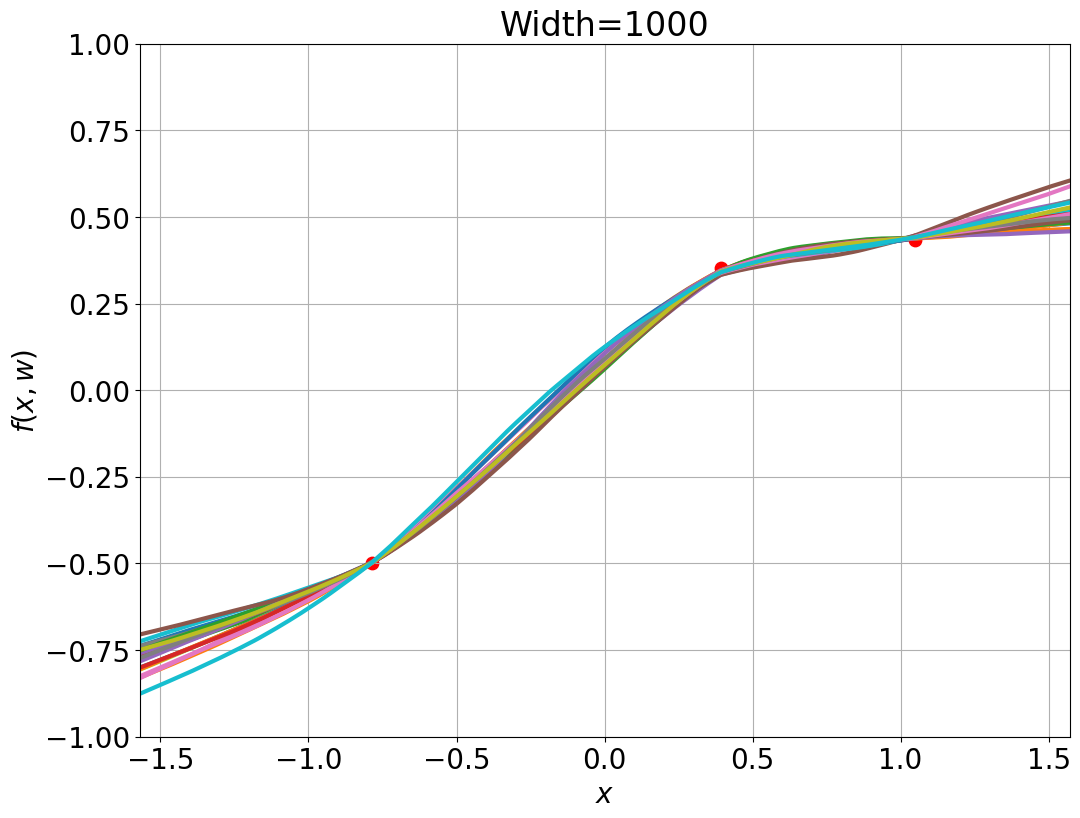

<ipython-input-12-4dc33260fcb0>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread('train_fig.png'))


<Figure size 1200x900 with 0 Axes>

In [ ]:
iters = 100
steps_per_iter = 5
lr = 1e-3
imgs = []
for i in tqdm_notebook(range(iters)):
    for line, net in zip(lines, all_nets):
        gd(net, xin, yin, iters=steps_per_iter, lr=lr, progress_bar=False)
        line.set_data(x.detach().cpu(), net(x).detach().cpu())
    nbf.update()
    imgs.append(imageio.imread('train_fig.png'))
plt.savefig("train_fig2.png")

In [ ]:
imgs2 = [im0]*5+list(imgs)
imageio.mimwrite(f'gifs/train_progress.gif', imgs2, duration=0.1)

xs = {}
budges = {}
losses = {}

gif = False # False for faster training, if true will be slower but live updates the above figure
eps = 1e-5
iters = 2000
steps_per_iter = 1
lr = 1e-3

#### Graph

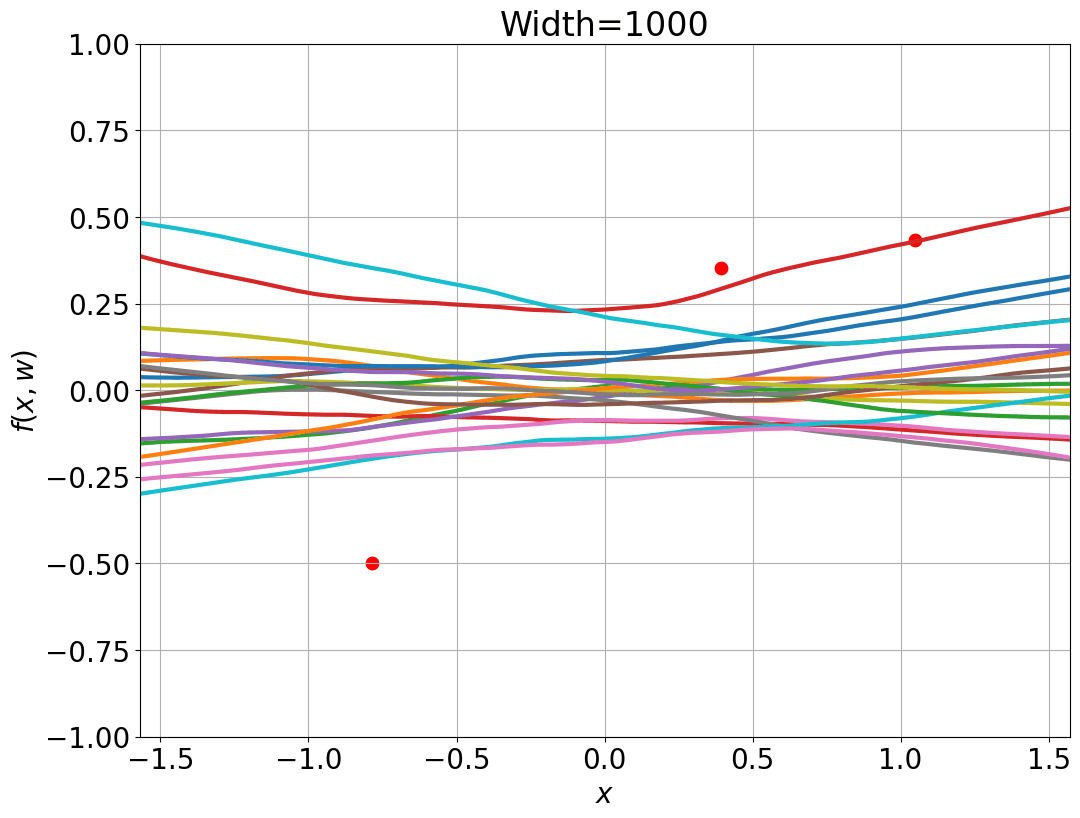

In [ ]:
from IPython.display import Image
Image(open('/content/gifs/train_progress.gif', 'rb').read())  # local

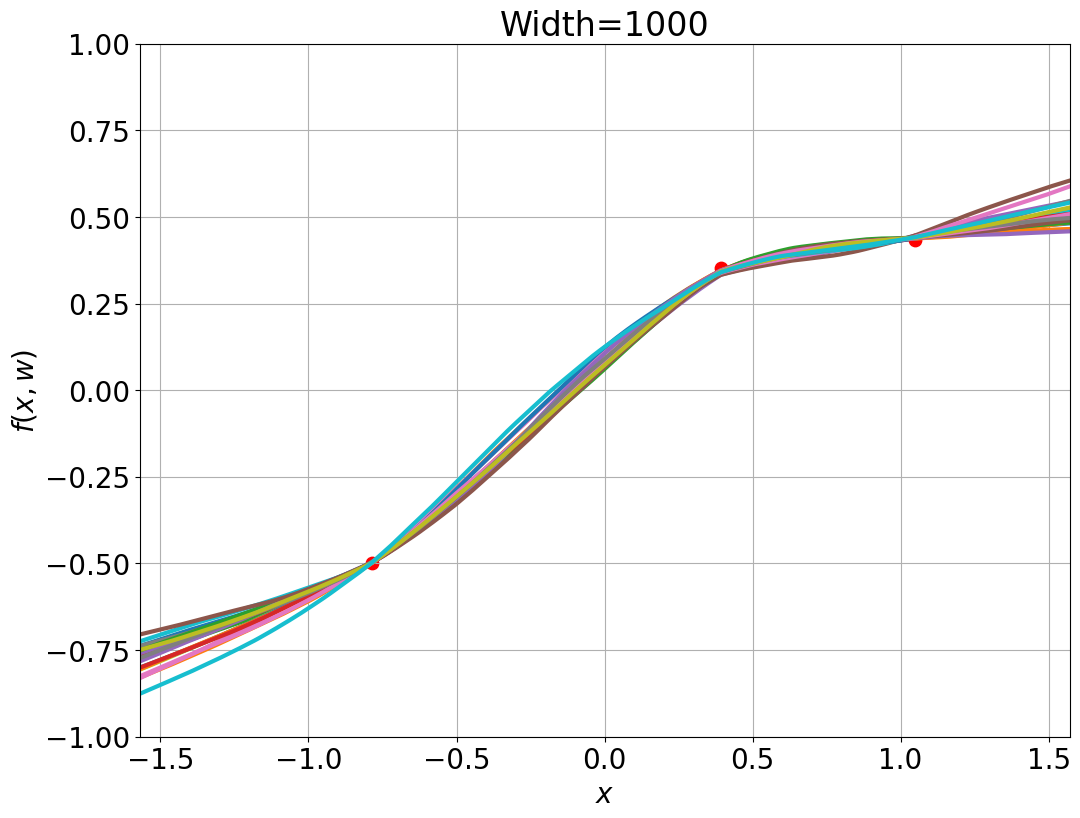

In [ ]:
Image(open('/content/train_fig.png', 'rb').read())  # local

The graph above shows tha training process of 20 randomly initialized 2-hidden layer, width 1000 Relu network. the three red points are the sample points.<br>
The first graph shows that 20-network at initialization, and the second graph is 20-network after training. 
The three red dots on the graph are samples, and they are obtained using the following formular:<br>
$$y = sinx*cosx$$

### Lazy Training

In the of linear regression models, having an infinite number of parameters would likely result in overfitting. However, contrary to this situation, Lazy Training has shown that neural networks with an infinite number of neurons are more stable. Specifically, during the training process, the weights of the neural networks are barely changed. 

In 2019, Lenaic Chizat, Edouard Oyallon, Francis Bach has demonstrated the effectiveness of Lazy Training in two layers neural network, by using NTK. [On Lazy Training in Differentiable Programming](https://arxiv.org/abs/1812.07956).

#### Code

In [ ]:
import numpy as np
for m in [50, 100, 1000]:
    f = create_net(width=m, bias=True, hidden_layers=2).to(device)
    #weights0 = list(f.modules())[4].weight.detach().cpu.numpy().copy()
    allw0 = nn.utils.parameters_to_vector(f.parameters()).detach().cpu().numpy().copy()
    
    imgs = []
    imgs2 = []
    xvals = [0]
    budgevals = [0]
    lossvals = []
    t = tqdm_notebook(range(iters), desc=f'm={m}')
    for i in t:
        ls = gd(f, xin, yin, iters=steps_per_iter, lr=lr, progress_bar=False)
        lossvals.extend(ls)
        t.set_postfix(loss=ls[-1])
    #     l.set_data(x.detach(), f(x).detach())
        #weights = list(f.modules())[4].weight.detach().cpu().numpy().copy()
        allw = nn.utils.parameters_to_vector(f.parameters()).detach().cpu().numpy().copy()
        budge = np.linalg.norm(allw-allw0)/np.linalg.norm(allw0)
        xvals.append((i+1)*steps_per_iter)
        budgevals.append(budge)
        if ls[-1]<eps:
            break
    
    xs[m] = xvals.copy()
    budges[m] = budgevals.copy()
    losses[m] = lossvals.copy()   

<ipython-input-15-53bcc462f3bb>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(range(iters), desc=f'm={m}')


m=50:   0%|          | 0/2000 [00:00<?, ?it/s]

m=100:   0%|          | 0/2000 [00:00<?, ?it/s]

m=1000:   0%|          | 0/2000 [00:00<?, ?it/s]

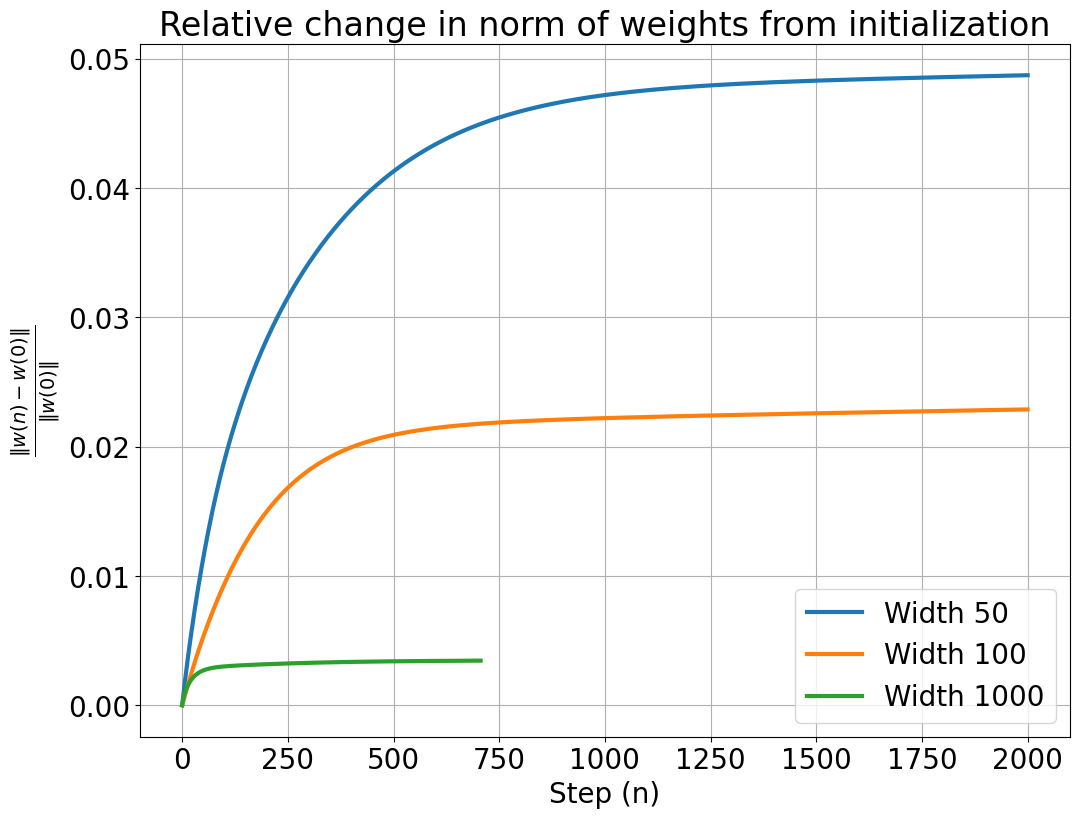

In [ ]:
from google.colab import files
plt.figure()
plt.title(f"Relative change in norm of weights from initialization")
for m in sorted(xs.keys()):
    plt.plot(xs[m], budges[m], label=f"Width {m}")
plt.xlabel("Step (n)")
plt.ylabel(r"$\frac{\Vert w(n) -  w(0) \Vert}{\Vert w(0) \Vert}$")
plt.legend()
plt.savefig("change.png")
plt.show()

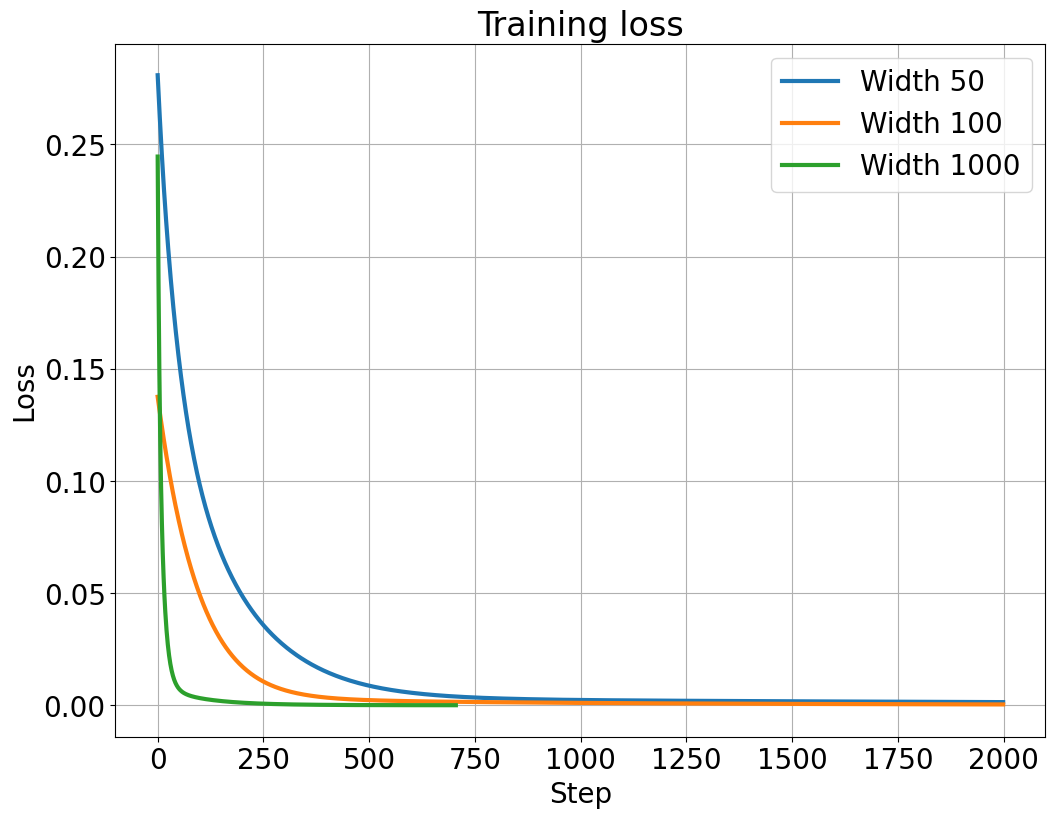

In [ ]:
plt.figure()
plt.title(f"Training loss")
for m in sorted(xs.keys()):
    plt.plot(range(len(losses[m])), losses[m], label=f"Width {m}")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()

#### Graph

We define three 2 layers network, but with different width.

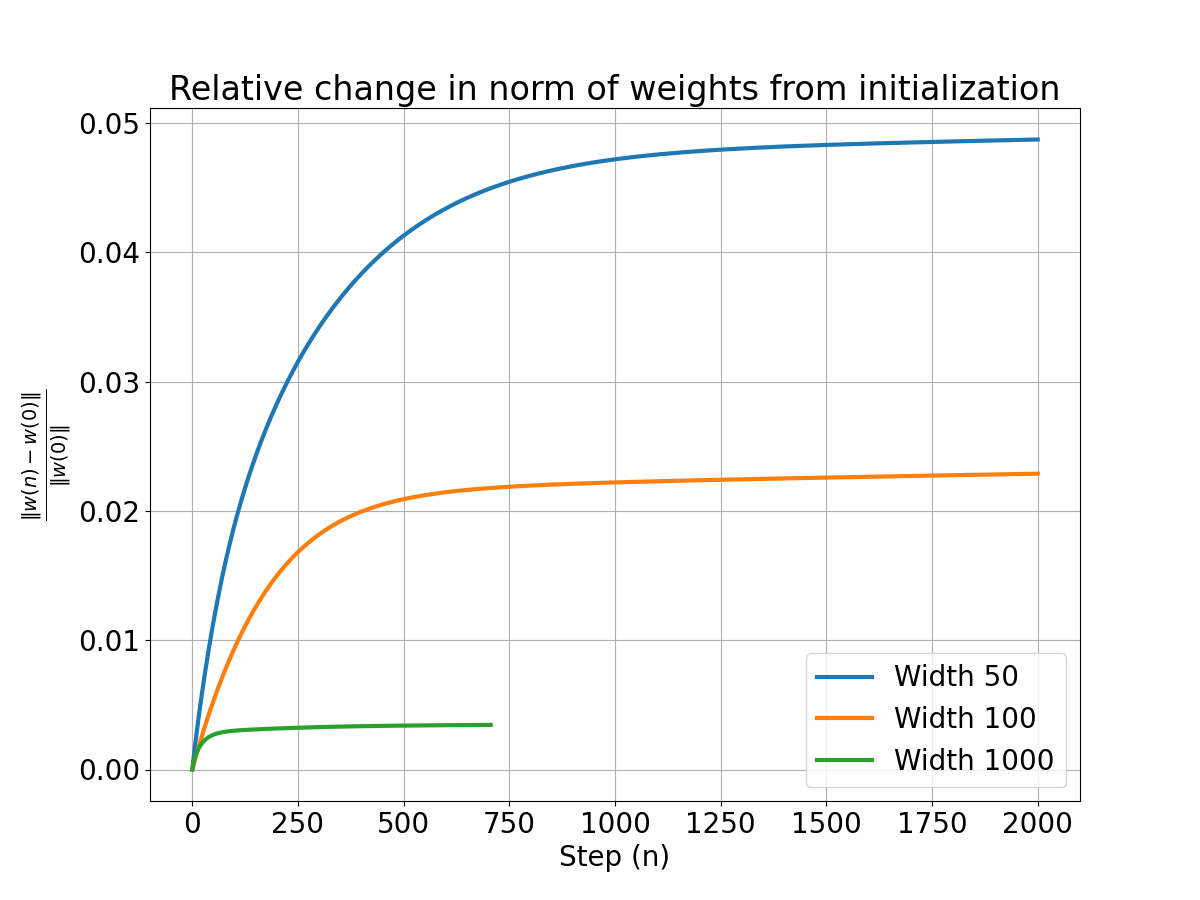

In [ ]:
Image(open('/content/change.png', 'rb').read())  # local

The graph above shows the relative change in norm of weight from initialization:<br>
$$\frac{||w(n)-w_0||_2}{||w_0||_2}$$
<br>
This is noticeable that when we comparing networks with different width, the relative change in norm of weight are more consistent in network with larger width.

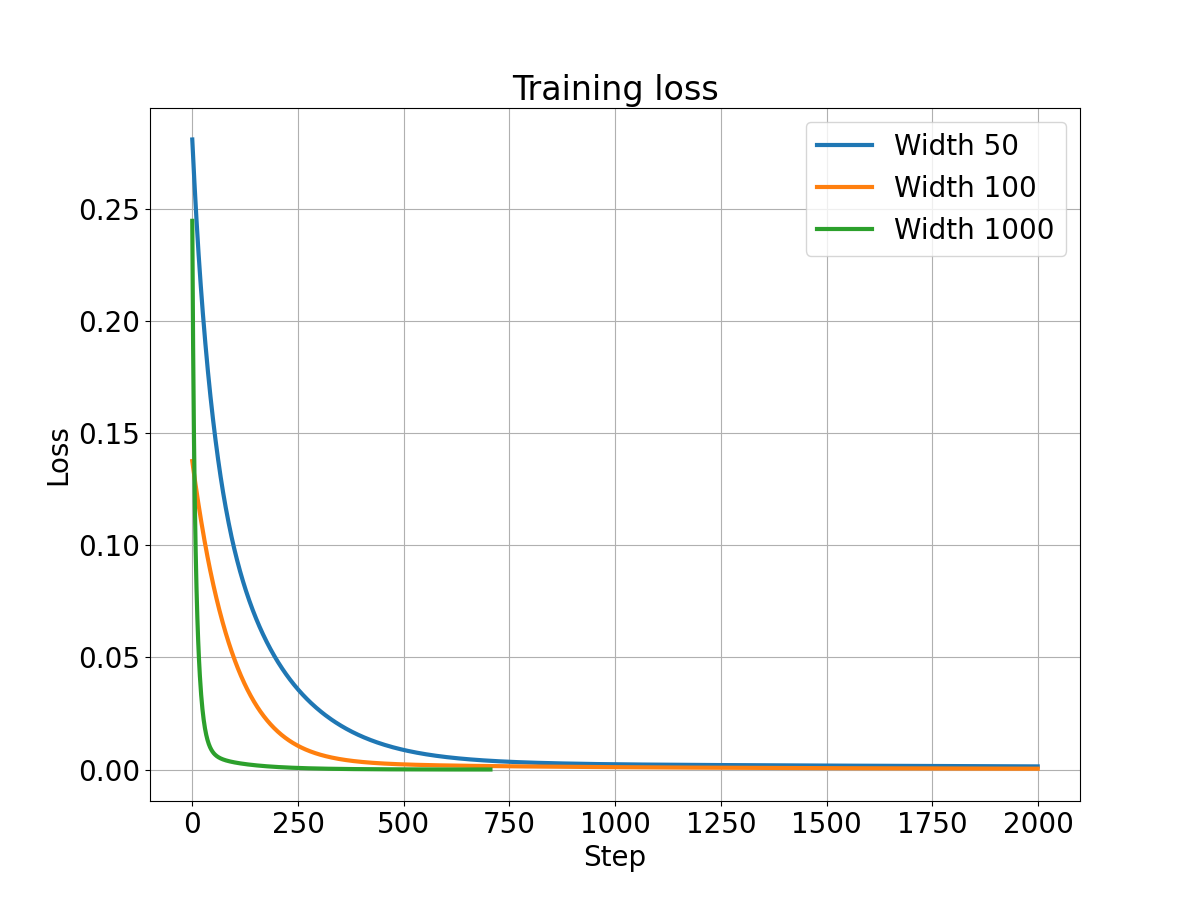

In [ ]:
Image(open('/content/loss.png', 'rb').read())

The above shows the training loss of the three networks during training.<br>
It is evident that deeper networks achieve a faster convergence to zero loss compared to other networks

## Limitations

Some assumptions are made in this paper when proving the aforementioned results for ANNs during training. One such example is that the ANNs are fully connected and are infinite width. This means that for a finite width network, the convergence and accuracy might be affected.

As the width grows, one would expect the convergence during training to increase due to the number of parameters that is needed to be optimized. The accuracy on the training data would increase but the model could be overfit to the data; this would result in poor accuracy in a testing dataset.

Bringing this back to the paper, the inductive proofs on the results of NTK are based on the asympototic behavior of infinite width. So the results are only valid when the width of each layer are very big.

## Future Directions

An interesting results on the NTK results is that the depth of the ANN is not limited. It is actually shown that the depth is a parameter of the function space of the kernel gradient descent.

A possible future direction of research is the behavior of NTKs on ANNs with at infinite depth. A few questions that can be asked are:

- What is the limiting function space of kernel gradient descent.
- What are the empirical results of NTK on the training process of ANNs at this limit.
- The tradeoffs at high width vs high depth with respect to the results of NTK.

Another possible future direction is an empirical study on the effect of the width of a network on generalization and convergence during training with respect to NTKs. Since in the real world, the actual width is never infinity, futher results should be shown for different large widths.


##Appendix

[Colab link for the code](https://colab.research.google.com/drive/1nKgXLq_TzENhd4q6rbT6dlL18G6oCIcX?usp=sharing)

##Reference
[Neural Tangent Kernel: Convergence and Generalization in Neural Networks](https://arxiv.org/abs/1806.07572)<br>
[On Lazy Training in Differentiable Programming](https://arxiv.org/abs/1812.07956).<br>
[Understanding the Neural Tangent Kernel](https://rajatvd.github.io/NTK/)